In [24]:
# %load diffsolver.py
import numpy as np
import matplotlib.pyplot as plot


class OdeTime:
    
    def __init__(self, t_from, t_to, t_intervals):
        self.t_from = t_from
        self.t_to = t_to
        self.t_intervals = t_intervals
        self.dt = (t_to - t_from) / float(t_intervals)

    def time(self, i):
        return self.t_from + self.dt * float(i)


class OdeInput:
    
    #input
    #    time: odeTime
    #    initialValues: numpy matrix of dimension 1*n
    
    def __init__(self, time, initial_values):
        self.time = time
        self.initial_values = initial_values
    
    def length(self):
        return self.time.t_intervals+1
    
    def dimension(self):
        return self.initial_values.shape[0]


class OdeOutput:
    
    def __init__(self, ode_input):
        self.ode_input = ode_input
        self.results = np.zeros((ode_input.length(), ode_input.dimension()))
        self.times = np.zeros((ode_input.length(), 1))
    
    def length(self):
        return self.ode_input.length()
    
    def dimension(self):
        return self.ode_input.dimension()
    

class OdeSolver:
    
    def __init__(self, time_info, initial_values):
        ode_input = OdeInput(time_info, initial_values)
        self.ode_input = ode_input
        self.ode_output = OdeOutput(ode_input)
        
    def equation(self, t, x):
        return x
    
    def solve(self):
        dt = self.ode_input.time.dt

        # new value is set to the initial data at first
        new_value = self.ode_input.initial_values
        
        # save initial data to output
        self.ode_output.results[0] = new_value
        self.ode_output.times[0] = self.ode_input.time.time(0)
        
        for i in range(1, self.ode_input.length()):
            # move new values to old values
            old_value = new_value
            
            time_old = self.ode_input.time.time(i - 1)
            
            k1 = self.equation(time_old, old_value)
            k2 = self.equation(time_old + 0.5 * dt, 0.5 * dt * k1 + old_value)
            k3 = self.equation(time_old + 0.5 * dt, 0.5 * dt * k2 + old_value)
            k4 = self.equation(time_old + 1.0 * dt, 1.0 * dt * k3 + old_value)
            
            new_value = old_value + (dt / 6.0) * (1.0 * k1 + 2.0 * k2 + 2.0 * k3 + 1.0 * k4)
            
            self.ode_output.results[i] = new_value
            self.ode_output.times[i] = self.ode_input.time.time(i)
            
    def print_result(self):
        print("Solved ODE")
        print("Initial value: ", self.ode_input.initial_values)
        print("Output:")
        for i in range(0, self.ode_output.length()):
            t = self.ode_input.time.time(i)
            print("t: ", t, "y: ", self.ode_output.results[i])

    def print_graph(self):
        x = self.ode_output.times
        for i in range(0, self.ode_output.dimension()):
            plot.plot(x, self.ode_output.results[:, i])
        plot.show()

In [25]:
time_info = OdeTime(0.0, 1.0, 100)
initial_value = np.array([1.0])
solver = OdeSolver(time_info, initial_value)

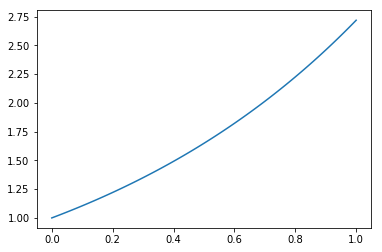

In [26]:
solver.solve()
solver.print_graph()

In [52]:
class PredatorPrey(OdeSolver):
    
    def __init__(self, time_info, initial_values, a, b, c, d):
        OdeSolver.__init__(self, time_info, initial_values)
        self.a = a
        self.b = b
        self.c = c
        self.d = d
    
    def equation(self, t, x):
        x1 = self.a * x[0] - self.b * x[0] * x[1]
        x2 = -self.c * x[1] + self.d * x[0] * x[1]
        return np.array([x1, x2])

In [62]:
time_info2 = OdeTime(0.0, 50.0, 10000)
initial_value2 = np.array([15.0, 20.0])
solver2 = PredatorPrey(time_info2, initial_value2, a=2.0, b=1.0, c=1.0, d=1.0)

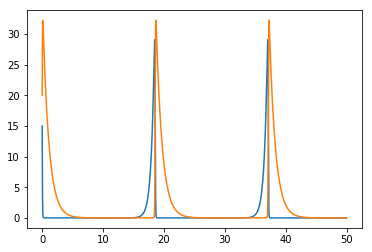

In [63]:
solver2.solve()
solver2.print_graph()

In [19]:
# %load model.py
import numpy as np


class DiscreteModel:

    def __init__(self, items, probs):
        if len(items) != len(probs):
            raise ValueError("length of items and probability must match")

        self.prob_dict = dict()
        for item, prob in zip(items, probs):
            self.prob_dict[item] = prob

    def update(self, data, hypothesis, likelihood):
        self.prob_dict[hypothesis] *= likelihood(data, hypothesis)

    def normalize(self):
        total = 0.0
        for hypothesis in self.prob_dict:
            total += self.prob_dict[hypothesis]
        for hypothesis in self.prob_dict:
            self.prob_dict[hypothesis] /= total


class GridInfo:

    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps


class Grid4DModel(DiscreteModel):

    # domain: array of GridInfo()
    def __init__(self, domain):
        if len(domain) != 4:
            raise ValueError("This is 4D Model")

        tuples = []
        for a in np.linspace(domain[0].start, domain[1].end, num=domain[1].steps):
            for b in np.linspace(domain[1].start, domain[1].end, num=domain[1].steps):
                for c in np.linspace(domain[2].start, domain[2].end, num=domain[2].steps):
                    for d in np.linspace(domain[3].start, domain[3].end, num=domain[3].steps):
                        tuples.append((a, b, c, d))
        probs = [1 for i in range(len(tuples))]

        DiscreteModel.__init__(self, tuples, probs)

    def marginal_distribution(self, dim):
        if dim > 3:
            raise ValueError("This is 4D Model")
        if dim < 0:
            raise ValueError("No Minus")
        marginal = {}
        for tuple_grid in self.prob_dict.keys():
            if tuple_grid[dim] in marginal:
                marginal[tuple_grid[dim]] += self.prob_dict[tuple_grid]
            else:
                marginal[tuple_grid[dim]] = self.prob_dict[tuple_grid]
        marginal_tuple = [(k, v) for k, v in marginal.items()]
        marginal_tuple.sort(key=lambda x: x[0])
        marginal_np = np.zeros(shape=(len(marginal_tuple), 2))
        for i in range(len(marginal_tuple)):
            marginal_np[i, :] = marginal_tuple[i]
        return marginal_np

In [28]:
a_range = GridInfo(0.0, 15.0, 6)
b_range = GridInfo(1.0, 10.0, 5)
c_range = GridInfo(3.0, 10.0, 3)
d_range = GridInfo(5.0, 10.0, 8)

grid = Grid4DModel([a_range, b_range, c_range, d_range])
print(grid.marginal_distribution(0))
print(grid.marginal_distribution(1))
print(grid.marginal_distribution(2))
print(grid.marginal_distribution(3))

[[   0.   120. ]
 [   2.5  120. ]
 [   5.   120. ]
 [   7.5  120. ]
 [  10.   120. ]]
[[   1.    120.  ]
 [   3.25  120.  ]
 [   5.5   120.  ]
 [   7.75  120.  ]
 [  10.    120.  ]]
[[   3.   200. ]
 [   6.5  200. ]
 [  10.   200. ]]
[[  5.          75.        ]
 [  5.71428571  75.        ]
 [  6.42857143  75.        ]
 [  7.14285714  75.        ]
 [  7.85714286  75.        ]
 [  8.57142857  75.        ]
 [  9.28571429  75.        ]
 [ 10.          75.        ]]
